In [369]:
import os
import io

import cv2 as cv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image as pil_image
from IPython.html import widgets

from ipywidgets import interact, interact_manual
from IPython.display import display, Image, clear_output

# Utilities

In [370]:
def imgs_show(imgs, rows, fontsize=36):
    fig = plt.figure()
    for n, (img, title) in enumerate(imgs):
        a = fig.add_subplot(rows, np.ceil(len(imgs)/float(rows)), n + 1)
        a.set_title(title, fontdict={"fontsize": fontsize})
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
    plt.show()

def read_folder(folder, ext):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(ext):
            path = os.path.join(folder, filename)
            images.append(np.array(pil_image.open(path)))
    return images

def img_show(img, title = '', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.gray()
    plt.imshow(img)
    plt.title(title)
    plt.show()

def display_frames_sequence(frames):
    def exec(i):
        a = np.uint8(frames[i])
        f = io.StringIO()

        imgByteArr = io.BytesIO()
        pil_image.fromarray(a, 'RGB').save(imgByteArr, format='PNG')
        display(Image(data=imgByteArr.getvalue()))
        
    widgets.interact(exec, i=widgets.IntSlider(min=0, max=len(frames) - 1, step=1, value=0))
    
def read_frames_dataset(path, sep=',', ext='.jpg'):
    frames = read_folder(os.path.join(path, 'img/'), ext)
    df = pd.read_csv(os.path.join(path, 'groundtruth_rect.txt'), names=['x', 'y', 'w', 'h'], sep=sep)
    return frames, df

def enreach_single_frame_with_tracking_ractangle(frame, track_window, color=(0, 255, 0)):
    x,y,w,h = track_window
    return cv.rectangle(np.copy(frame), (x,y), (x+w,y+h), color, 2)

def enreach_frames_with_tracking_ractangle(frames, tracking_df, color=(0, 255, 0)):
    enreached_frames = []
    for i, frame in enumerate(frames):
        row = tracking_df.iloc[i]
        enreached_frame = enreach_single_frame_with_tracking_ractangle(
            frame, 
            (row['x'], row['y'], row['w'], row['h']),
            color
        )
        enreached_frames.append(enreached_frame)
    return enreached_frames

def write_video(path, frames):
    fourcc = cv.VideoWriter_fourcc(*'MP4V')
    h, w = frames[0].shape[:2]
    out = cv.VideoWriter(path + ".mp4", fourcc, 24, (w, h)) 
    for frame in frames:
        out.write(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    cv.destroyAllWindows()
    out.release()

# Load and configure data

[Datasets source](http://cvlab.hanyang.ac.kr/tracker_benchmark/datasets.html)

In [371]:
names = {
    "transformer": './datasets/Transformer/',
    "bike": './datasets/MountainBike/', 
    "girl": './datasets/Girl/', 
    "bolt": './datasets/Bolt/', 
    "car": './datasets/CarScale/'
}

In [372]:
transformer, transformer_df = read_frames_dataset(names["transformer"])
bike, bike_df = read_frames_dataset(names["bike"])
girl, girl_df = read_frames_dataset(names["girl"], sep='\t')
bolt, bolt_df = read_frames_dataset(names["bolt"])

car, car_df = read_frames_dataset(names["car"], sep='\t')

# example
transformer_df.head()

,x,y,w,h
0,196,51,139,194
1,192,46,145,202
2,196,46,140,193
3,195,48,140,199
4,190,46,146,199


# Mean shift

In [373]:
class MeanShift:
    
    # The termination criteria, either 10 iteration or move by atleast 1 pt
    TERMINATION_CRITERIA = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)
    
    COLOR_RED = (255, 0, 0)
    COLOR_GREEN = (0, 255, 0)
    
    HIST_RANGE = [0, 180]
    HIST_SIZE = [180]
    
    SCALE = 1
    
    def __init__(self, init_frame, config):
        self.init_frame = init_frame
        self.config = config
    
    @staticmethod
    def normalize_frame(img):
        normalized_img = np.copy(img)
        s = np.sum(img, axis=2)
        for i in range(img.shape[2]):
            normalized_img[:, :, i] = np.divide(img[:, :, i], s) * 255
        return normalized_img
        
    def fit(self, normalize=False):
        x, y, w, h = self.config["track_window"]
        roi = self.init_frame[y:y + h, x:x + w]
        
        if normalize:
            roi = MeanShift.normalize_frame(roi)
        
        new_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
        
        mask = cv.inRange(new_roi, np.array(self.config["ranges"]["min"]), np.array(self.config["ranges"]["max"]))
        
        imgs_show([
            (roi, "roi"),
            (new_roi, "hsv roi"),
            (new_roi[:,:,0], "hsv chan 0"), 
            (new_roi[:,:,1], "hsv chan 1"), 
            (new_roi[:,:,2], "hsv chan 2"),
            (mask, "mask")
        ], 1)
        
        hist = cv.calcHist(
            [new_roi], self.config["channels"], mask, MeanShift.HIST_SIZE, 
            [self.config["ranges"]["min"][0], self.config["ranges"]["max"][0]],
        )
        self.roi_hist = cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
    
    def predict(self, frame, normalize=False):
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        if normalize:
            hsv = MeanShift.normalize_frame(hsv)
        res = cv.calcBackProject(
            [hsv], self.config["channels"], self.roi_hist, 
            [self.config["ranges"]["min"][0], self.config["ranges"]["max"][0]], MeanShift.SCALE,
        )
        # apply meanshift to get the new location
        return cv.meanShift(res, self.config["track_window"], MeanShift.TERMINATION_CRITERIA)
    
    @staticmethod
    def run(frames, df, config, with_ground_truth=False, normalize=False):
        # get initial roi
        track_window = config["track_window"]
        
        # create and fit MeanShift instance
        mean_shift = MeanShift(frames[0], config)
        mean_shift.fit(normalize=normalize)
        
        result = [enreach_single_frame_with_tracking_ractangle(frames[0], track_window, MeanShift.COLOR_RED)]
        
        # predict other frames
        for frame in frames[1:]:
            _, track_window = mean_shift.predict(frame, normalize=normalize)
            result.append(enreach_single_frame_with_tracking_ractangle(frame, track_window, MeanShift.COLOR_RED))
        
        # add gound truth plots to images
        if with_ground_truth:
            for i, frame in enumerate(result):
                row = df.iloc[i]
                result[i] = enreach_single_frame_with_tracking_ractangle(
                    frame, 
                    (row['x'], row['y'], row['w'], row['h']),
                    MeanShift.COLOR_GREEN
                )
                
        return result

# Cam shift

In [374]:
class CamShift(MeanShift):
    def predict(self, frame, normalize=False): # prediction of the 
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        if normalize:
            hsv = MeanShift.normalize_frame(hsv)
        res = cv.calcBackProject(
            [hsv], self.config["channels"], self.roi_hist, 
            [self.config["ranges"]["min"][0], self.config["ranges"]["max"][0]], MeanShift.SCALE,
        )
        # apply meanshift to get the new location
        return cv.CamShift(res, self.config["track_window"], MeanShift.TERMINATION_CRITERIA)
    
    @staticmethod # method is absolutely the same, except creation of CamShift instance
    def run(frames, df, config, with_ground_truth=False, normalize=False):
        # get initial roi
        track_window = config["track_window"]
        
        # create and fit MeanShift instance
        mean_shift = CamShift(frames[0], config)
        mean_shift.fit(normalize=normalize)
        
        result = [enreach_single_frame_with_tracking_ractangle(frames[0], track_window, MeanShift.COLOR_RED)]
        
        # predict other frames
        for frame in frames[1:]:
            _, track_window = mean_shift.predict(frame, normalize=normalize)
            result.append(enreach_single_frame_with_tracking_ractangle(frame, track_window, MeanShift.COLOR_RED))
        
        # add gound truth plots to images
        if with_ground_truth:
            for i, frame in enumerate(result):
                row = df.iloc[i]
                result[i] = enreach_single_frame_with_tracking_ractangle(
                    frame, 
                    (row['x'], row['y'], row['w'], row['h']),
                    MeanShift.COLOR_GREEN
                )
                
        return result

# "Transformer" dataset

In [375]:
init = transformer_df.iloc[0]
print(init)
config = {
        "track_window": (init["x"], init["y"], init["w"], init["h"]),
        "channels": [0],
        "ranges": { 
            "min": (90., 0., 0.),
            "max": (135., 255., 255.)
        }
    }

x    196
y     51
w    139
h    194
Name: 0, dtype: int64


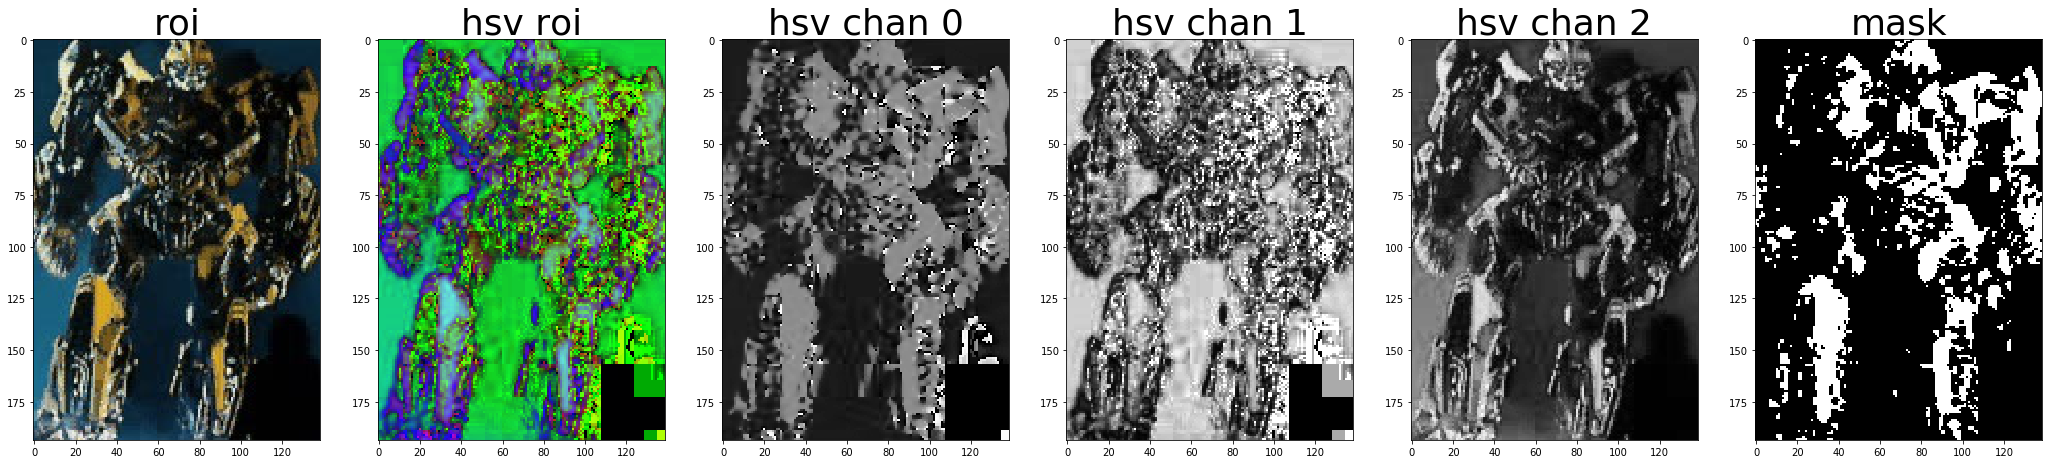

interactive(children=(IntSlider(value=0, description='i', max=123), Output()), _dom_classes=('widget-interact'…

In [376]:
# mean_shift
result_transformer = MeanShift.run(transformer, transformer_df, config, with_ground_truth=True)
display_frames_sequence(result_transformer)
write_video("./results/mean_shift_transformer", result_transformer)

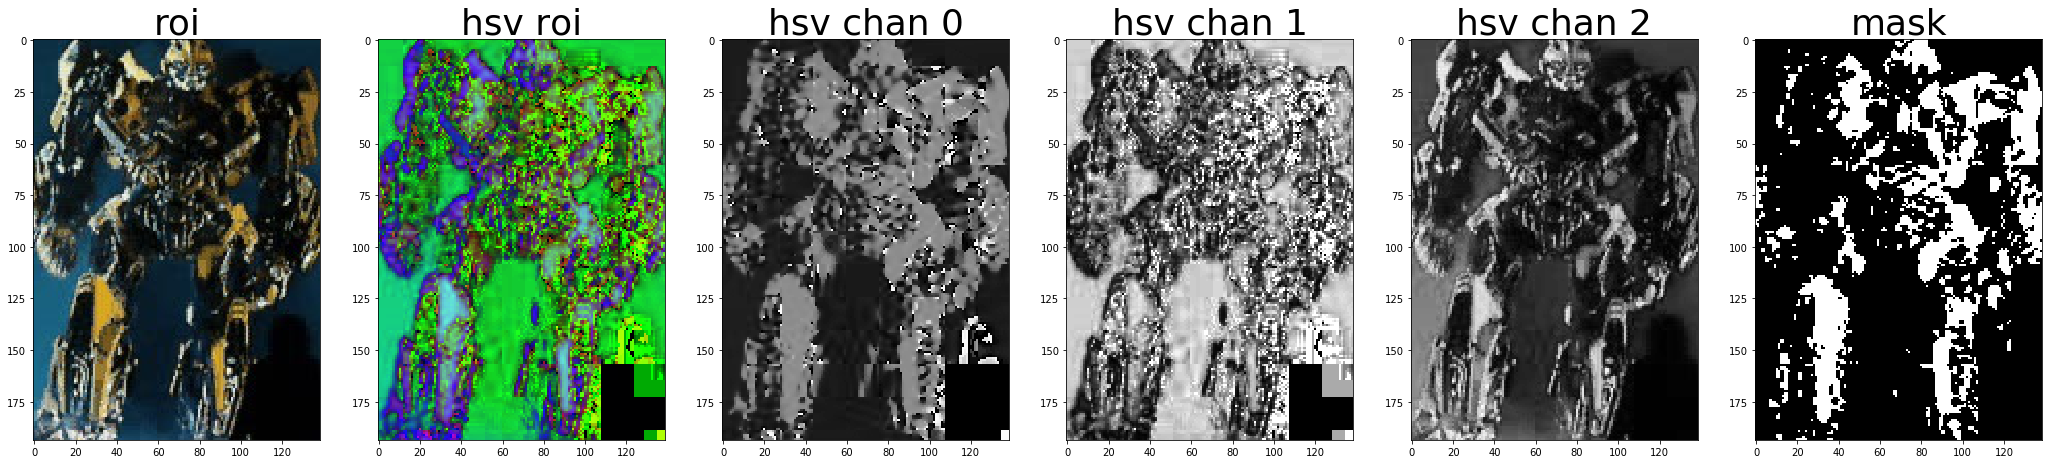

interactive(children=(IntSlider(value=0, description='i', max=123), Output()), _dom_classes=('widget-interact'…

In [377]:
# cam_shift
result_transformer = CamShift.run(transformer, transformer_df, config, with_ground_truth=True)
display_frames_sequence(result_transformer)
write_video("./results/cam_shift_transformer", result_transformer)

# "Bike" dataset

In [378]:
init = bike_df.iloc[0]
print(init)
config = {
        "track_window": (init["x"] + 35, init["y"] + 5, 21, 30),
        "channels": [0],
        "ranges": { 
            "min": (0., 0., 0.),
            "max": (80., 255., 255.)
        }
    }

x    319
y    185
w     67
h     56
Name: 0, dtype: int64


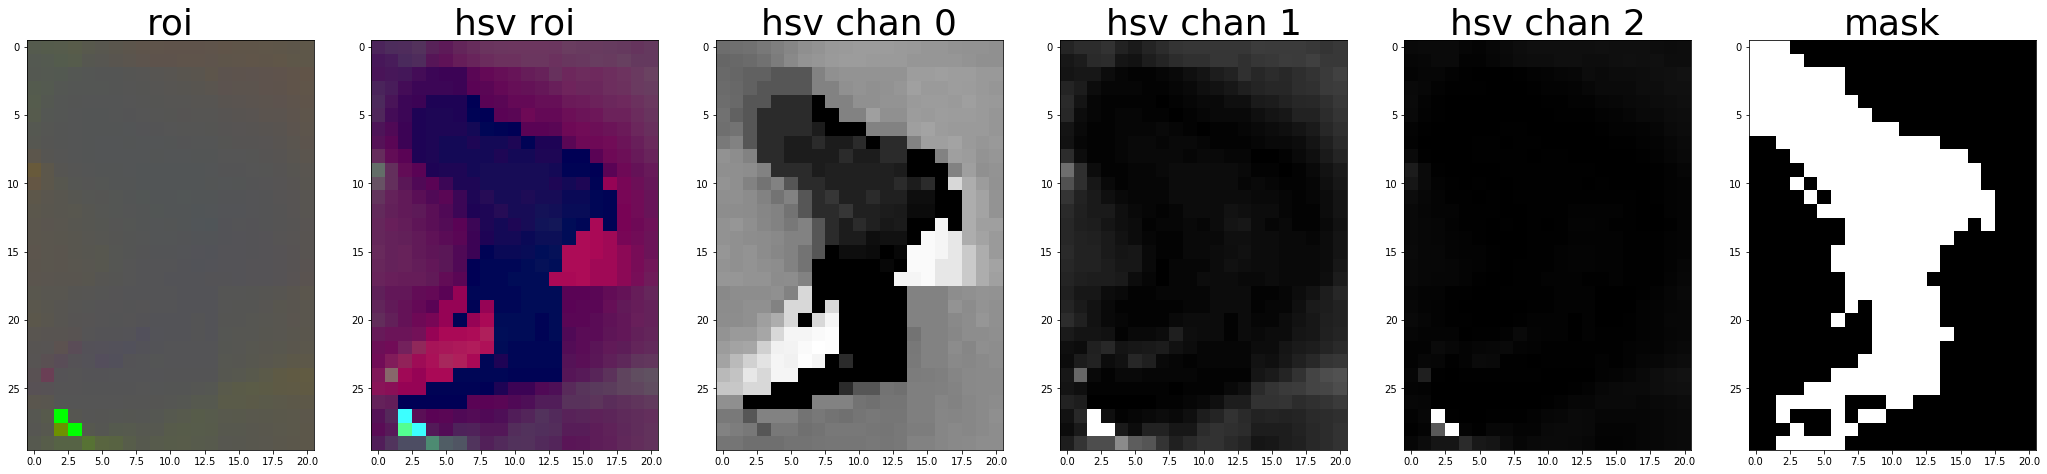

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


interactive(children=(IntSlider(value=0, description='i', max=227), Output()), _dom_classes=('widget-interact'…

In [379]:
# mean_shift
result_bike = MeanShift.run(bike, bike_df, config, with_ground_truth=True, normalize=True)
display_frames_sequence(result_bike)
write_video("./results/mean_shift_bike", result_bike)

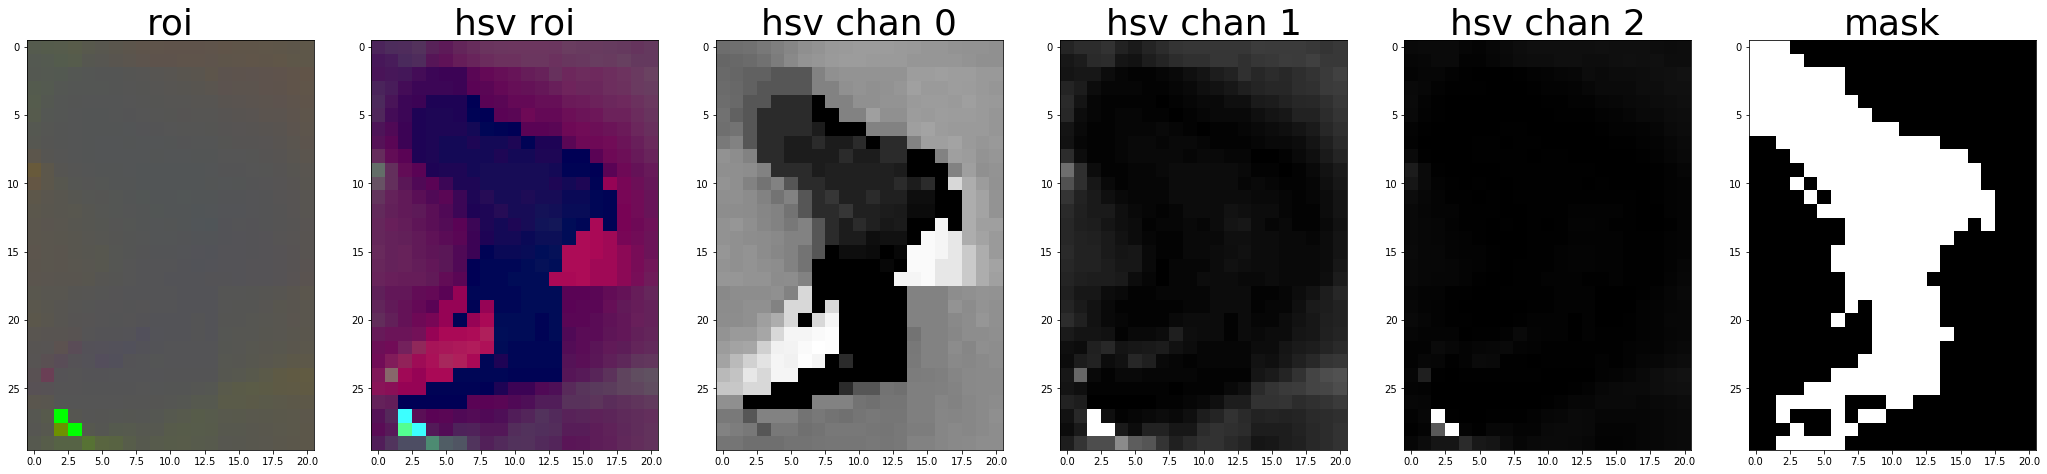

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


interactive(children=(IntSlider(value=0, description='i', max=227), Output()), _dom_classes=('widget-interact'…

In [380]:
# cam_shift
result_bike = CamShift.run(bike, bike_df, config, with_ground_truth=True, normalize=True)
display_frames_sequence(result_bike)
write_video("./results/cam_shift_bike", result_bike)

# "Girl" dataset

In [390]:
init = girl_df.iloc[0]
print(init)
config = {
        "track_window": (init["x"], init["y"], init["w"], init["h"]),
        "channels": [0],
        "ranges": { 
            "min": (90., 0., 0.),
            "max": (135., 255., 255.)
        }
    }

x    57
y    21
w    31
h    45
Name: 0, dtype: int64


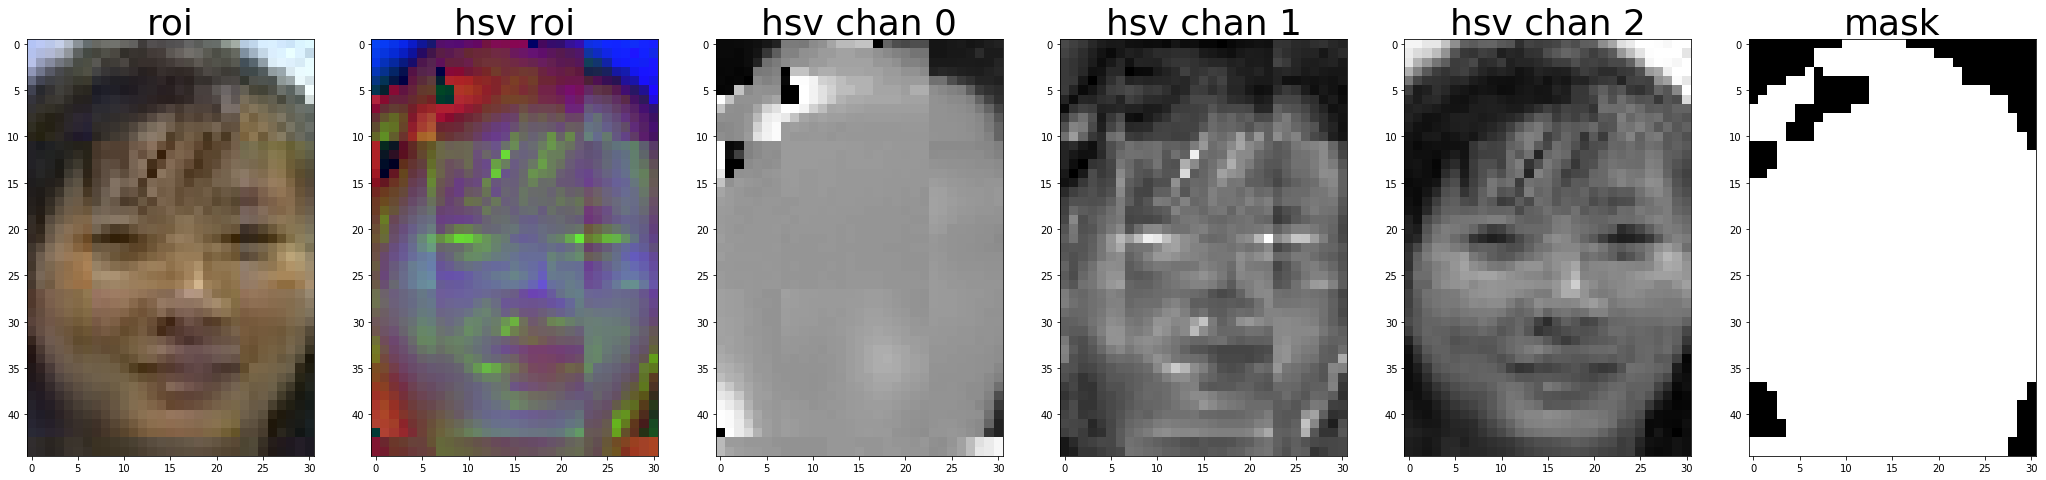

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

In [391]:
# mean_shift
result_girl = MeanShift.run(girl, girl_df, config, with_ground_truth=True)
display_frames_sequence(result_girl)
write_video("./results/mean_shift_girl", result_girl)

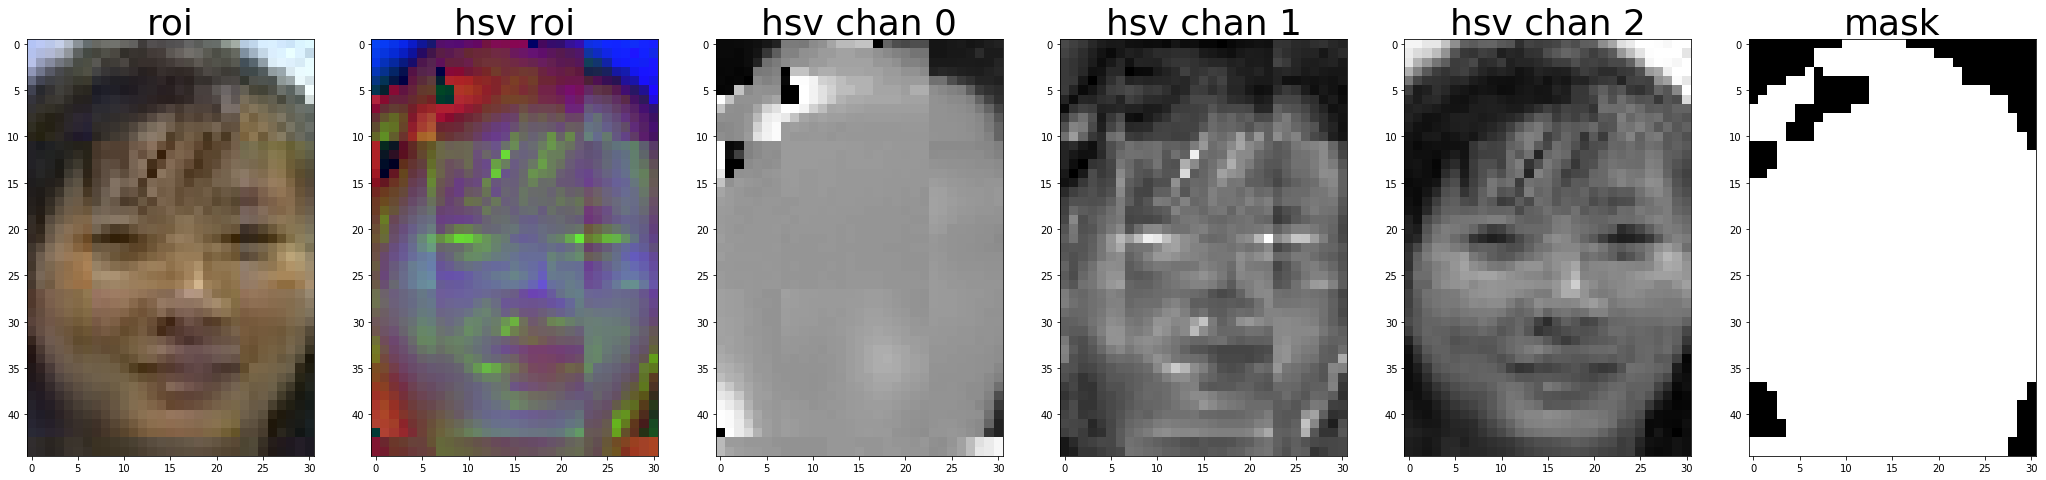

interactive(children=(IntSlider(value=0, description='i', max=499), Output()), _dom_classes=('widget-interact'…

In [383]:
# cam_shift
result_girl = CamShift.run(girl, girl_df, config, with_ground_truth=True)
display_frames_sequence(result_girl)
write_video("./results/cam_shift_girl", result_girl)

# "Bolt" dataset

In [384]:
init = bolt_df.iloc[0]
print(init)
config = {
        "track_window": (init["x"], init["y"], init["w"], init["h"]),
        "channels": [0],
        "ranges": { 
            "min": (50., 100., 0.),
            "max": (135., 200., 255.)
        }
    }

x    336
y    165
w     26
h     61
Name: 0, dtype: int64


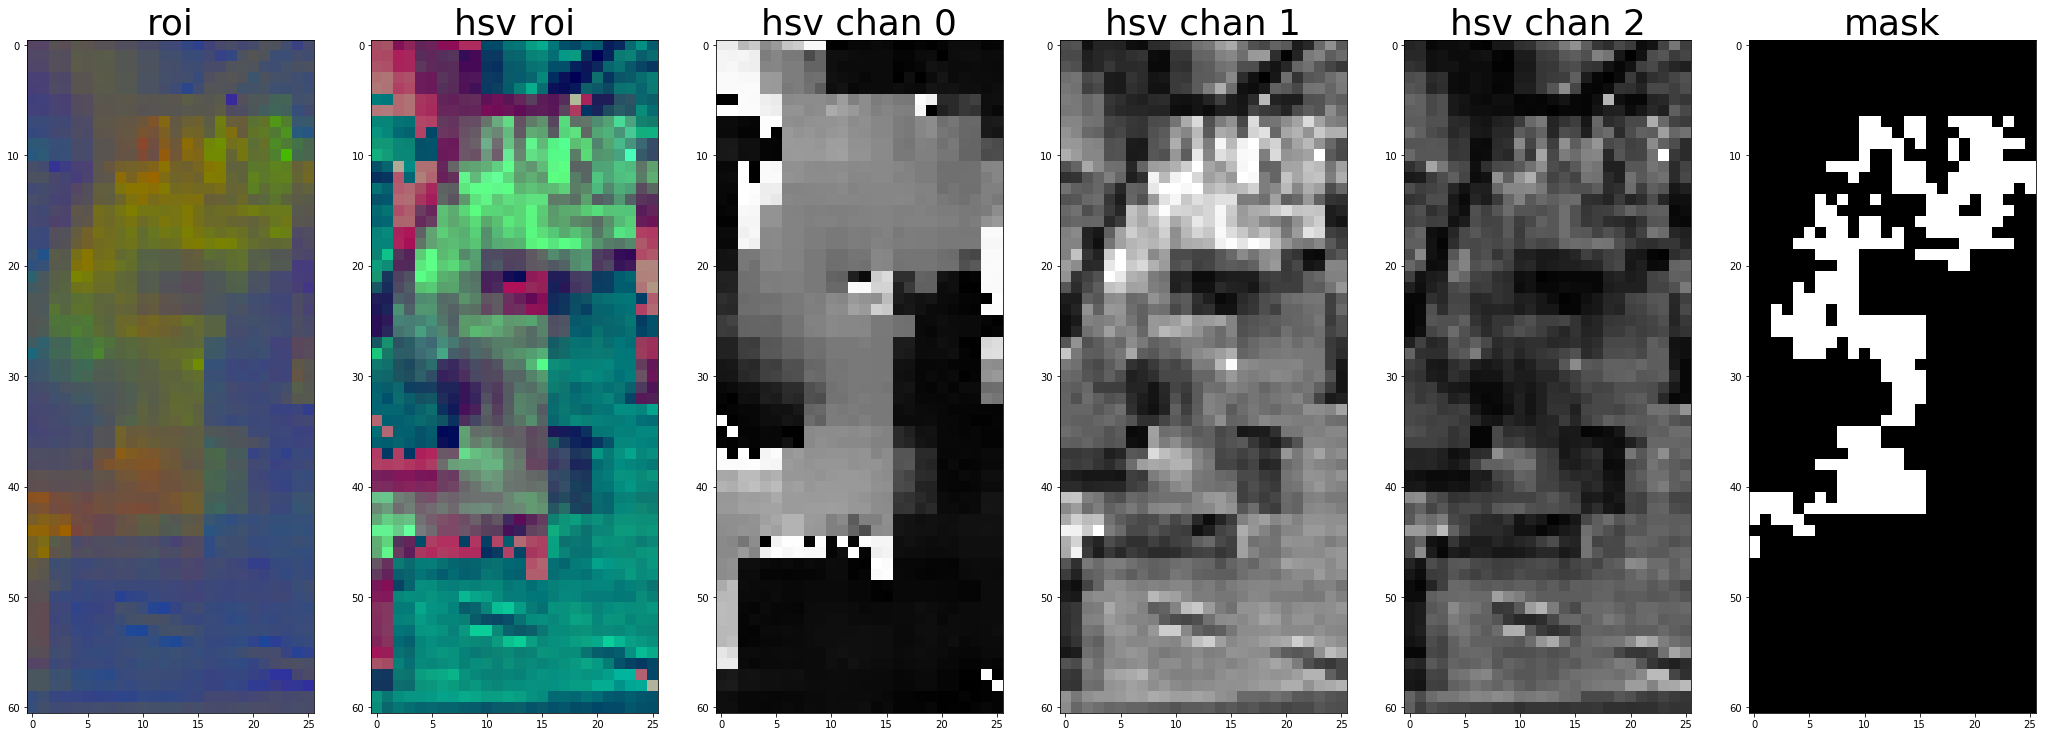

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


interactive(children=(IntSlider(value=0, description='i', max=349), Output()), _dom_classes=('widget-interact'…

In [385]:
# mean_shift
result_bolt = MeanShift.run(bolt, bolt_df, config, with_ground_truth=True, normalize=True)
display_frames_sequence(result_bolt)
write_video("./results/mean_shift_bolt", result_bolt)

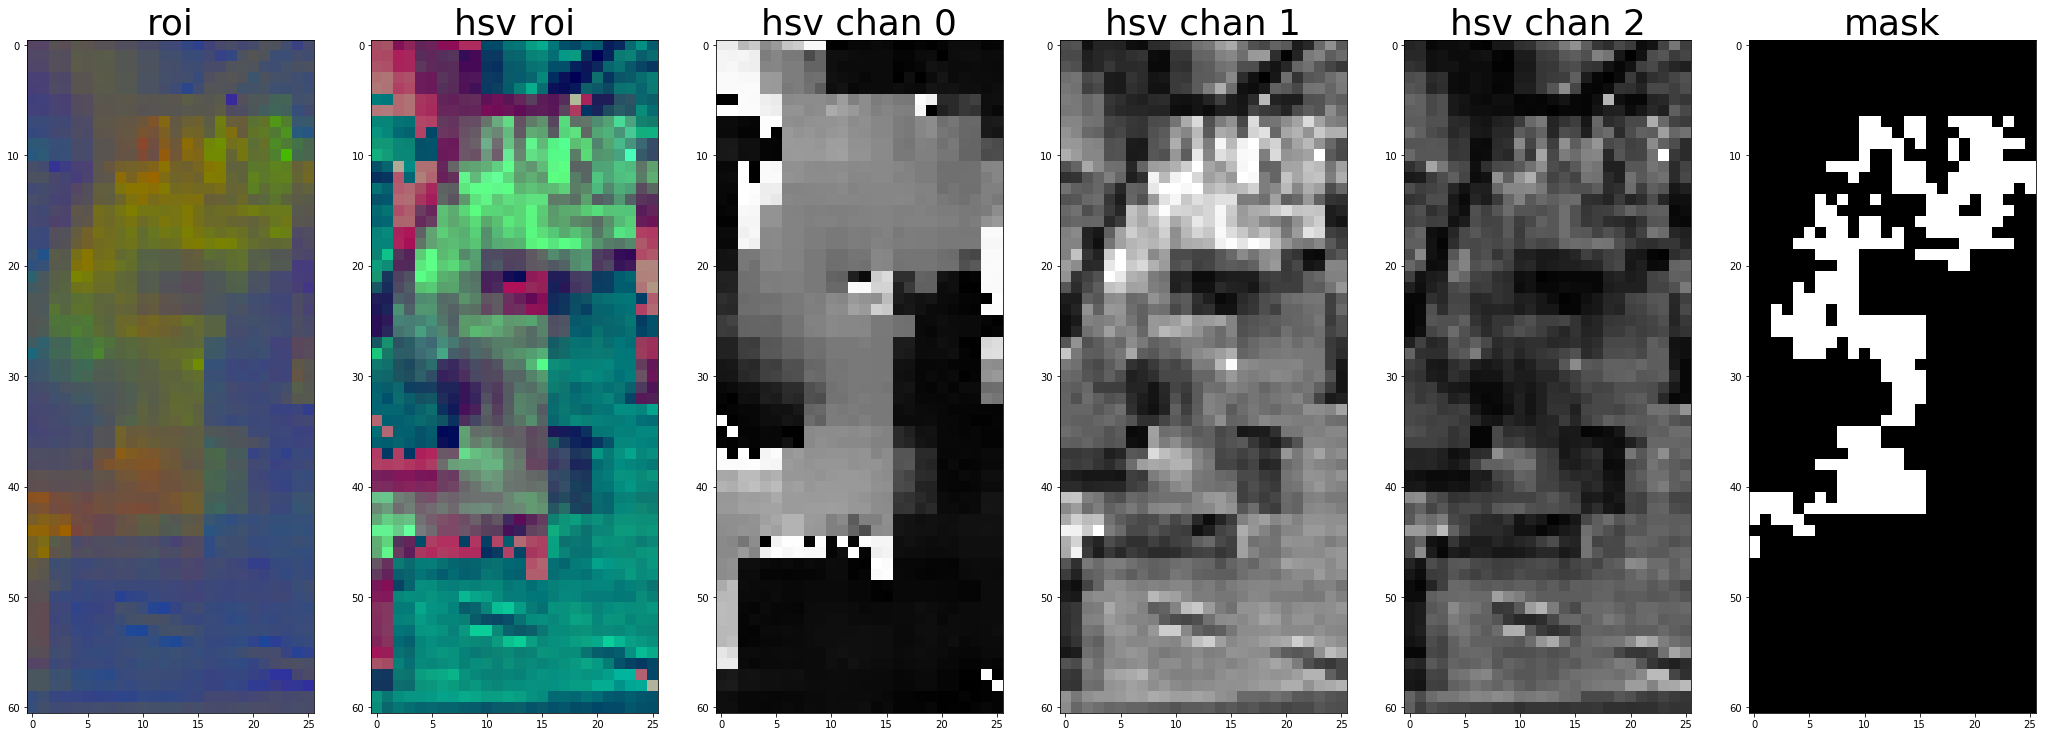

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


interactive(children=(IntSlider(value=0, description='i', max=349), Output()), _dom_classes=('widget-interact'…

In [386]:
# cam_shift
result_bolt = CamShift.run(bolt, bolt_df, config, with_ground_truth=True, normalize=True)
display_frames_sequence(result_bolt)
write_video("./results/cam_shift_bolt", result_bolt)

# "CarScale" dataset

In [387]:
init = car_df.iloc[0]
print(init)
config = {
        "track_window": (init["x"], init["y"], init["w"], init["h"]),
        "channels": [1],
        "ranges": { 
            "min": (0., 0., 0.),
            "max": (180., 50., 255.)
        }
    }

x      6
y    166
w     42
h     26
Name: 0, dtype: int64


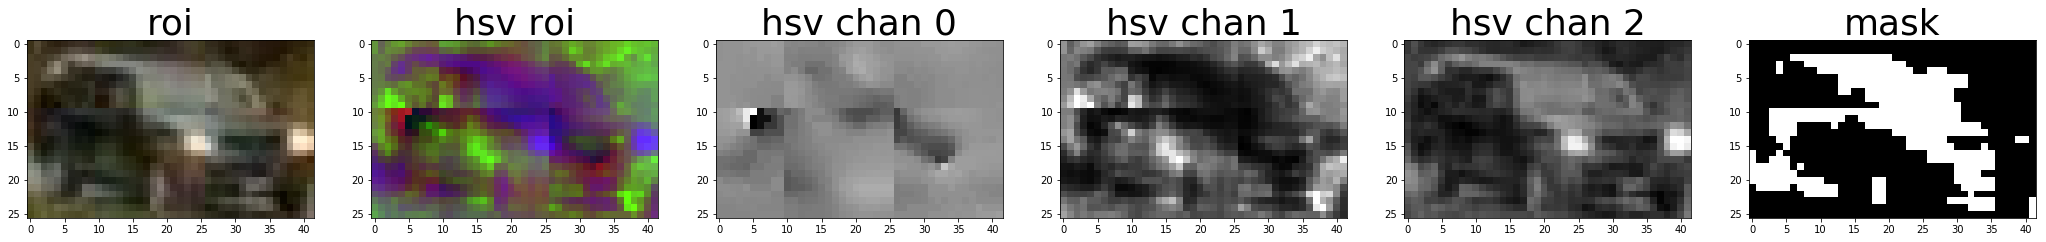

interactive(children=(IntSlider(value=0, description='i', max=251), Output()), _dom_classes=('widget-interact'…

In [388]:
# mean_shift
result_car = MeanShift.run(car, car_df, config, with_ground_truth=True)
display_frames_sequence(result_car)
write_video("./results/mean_shift_car", result_car)

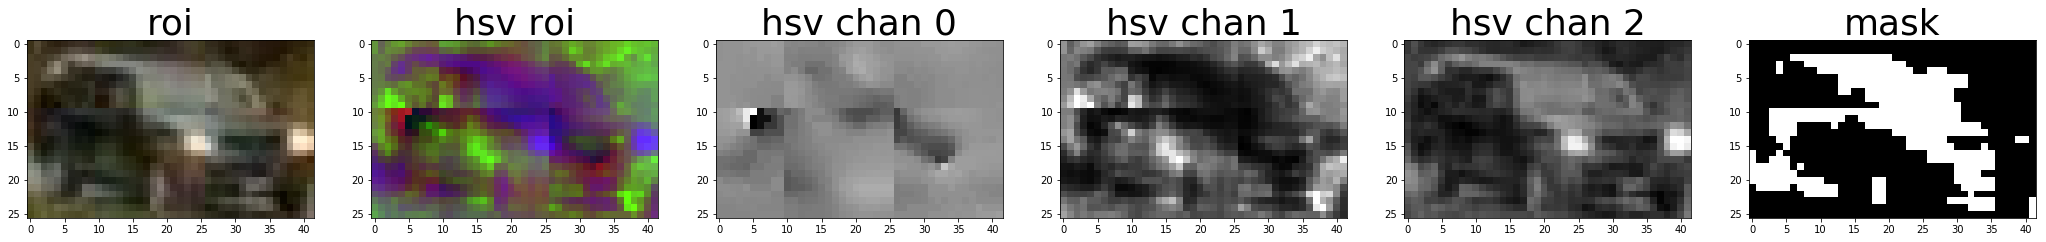

interactive(children=(IntSlider(value=0, description='i', max=251), Output()), _dom_classes=('widget-interact'…

In [389]:
# cam_shift
result_car = CamShift.run(car, car_df, config, with_ground_truth=True)
display_frames_sequence(result_car)
write_video("./results/cam_shift_car", result_car)

# Conclusions

Since **Mean shift** and **Cam Shift** algorithms are based on color distribution of image, they perform well in the case, when tracked object has different color, than background.

When the background has similar to tracked object colors this leads to algorithm failure.

**Mean shift** doesn't work really well on tracking objects with non constant size, since algorithm works with constant track window, on contrary **Cam Shift** could be applied to objects that changes size.